In [21]:
# import packages
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import numpy as np
import pandas as pd

# import data from csv file into a pandas df
cycle1_df = pd.read_csv("../Observations/cycle1.csv", low_memory=False)
cycle2_df = pd.read_csv("../Observations/cycle2.csv", low_memory=False)

# get the ids that intersect
cycle1_df_unique = np.unique(cycle1_df["Object_ID"])
cycle2_df_unique = np.unique(cycle2_df["Object_ID"])
intersect_ids = np.intersect1d(cycle1_df_unique, cycle2_df_unique)

# define sine function to fit
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset

In [ ]:
def queue_single_asteroid_by_id(asteroid_id):
    # check for asteroid id in dataframes
    id_in_cycle1 = not cycle1_df[cycle1_df["Object_ID"] == asteroid_id].empty
    id_in_cycle2 = not cycle2_df[cycle2_df["Object_ID"] == asteroid_id].empty

    # if not found in either dataframe, exit
    if not id_in_cycle1 and not id_in_cycle2:
        print(f"Asteroid {asteroid_id} not found in either dataset. Exiting.")
        return

    # process data if found in cycle1_df
    if id_in_cycle1:
        print(f"Asteroid {asteroid_id} found in Cycle 1 dataset. Processing...")
        asteroid = cycle1_df[cycle1_df["Object_ID"] == asteroid_id]
        process_asteroid_data(asteroid, asteroid_id, "Cycle 1")

    # process data if found in cycle2_df
    if id_in_cycle2:
        print(f"Asteroid {asteroid_id} found in Cycle 2 dataset. Processing...")
        asteroid = cycle2_df[cycle2_df["Object_ID"] == asteroid_id]
        process_asteroid_data(asteroid, asteroid_id, "Cycle 2")


def process_asteroid_data(asteroid, asteroid_id, dataset_name):
    """
    Derive the rotational period of an object from MJD
    and Magnitude, and plot the results.
    """
    # extract MJD, magnitude, magnitude error
    time_mdj = asteroid["MJD"].values
    magnitude = asteroid["Magnitude"].values
    error = asteroid["Magnitude_Error"].values

    # define frequency range (1 to 24 hours period = 1/24 to 1 cycles/hour)
    # convert MJD to hours relative to first timestamp
    time_hours = (time_mdj - time_mdj.min()) * 24
    frequency = np.linspace(1/(max(time_hours) - min(time_hours)), 1/2, 1000000)
    power = LombScargle(time_hours, magnitude, error).power(frequency)

    # best period is 1 / frequency at peak power
    best_frequency = frequency[np.argmax(power)]
    best_period = 1 / best_frequency

    # double the period for full rotation
    best_period = best_period * 2

    # create a lomb scargle model generating a sine curve fit
    ls = LombScargle(time_hours, magnitude, error)
    magnitude_fit = ls.model(time_hours, best_frequency)
    time_fit = np.linspace(0, best_period, len(magnitude_fit))
    magnitude_fit = ls.model(time_fit, best_frequency)
    phase = (time_hours % best_period)

    # plot the periodogram
    plt.figure(figsize=(10, 5))
    plt.plot(frequency, power)
    plt.title(f"Periodogram for {asteroid_id} ({dataset_name})")
    plt.xlabel("Frequency (1/hour)")
    plt.ylabel("Power")
    plt.grid(True)
    plt.show()

    # plot the lomb scargle model
    plt.figure(figsize=(10, 5))
    plt.plot(time_fit, magnitude_fit, color="orange", linewidth=3, label="Model Fit")
    plt.scatter(phase, magnitude, color="blue", label="Observed Data")
    plt.title(f"Light Curve Phase for {asteroid_id} ({dataset_name})")
    plt.xlabel("Hours")
    plt.ylabel("Magnitude")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.grid(True)
    plt.show()


Asteroid ID 1000 found in Cycle 1 dataset. Processing...


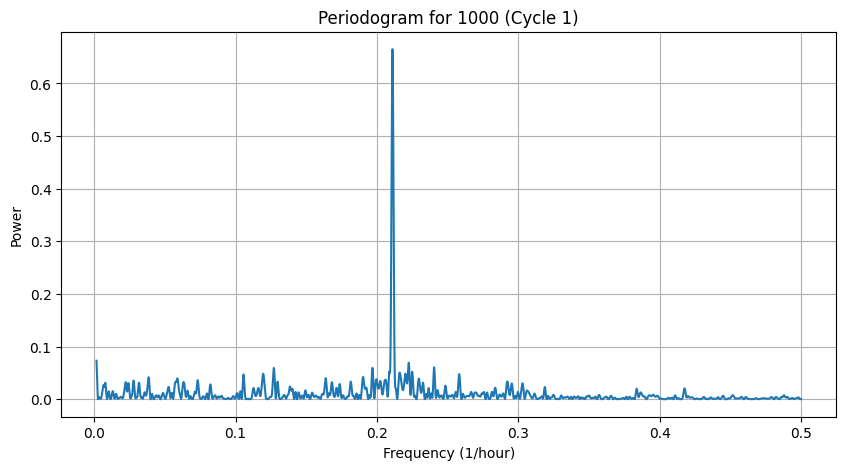

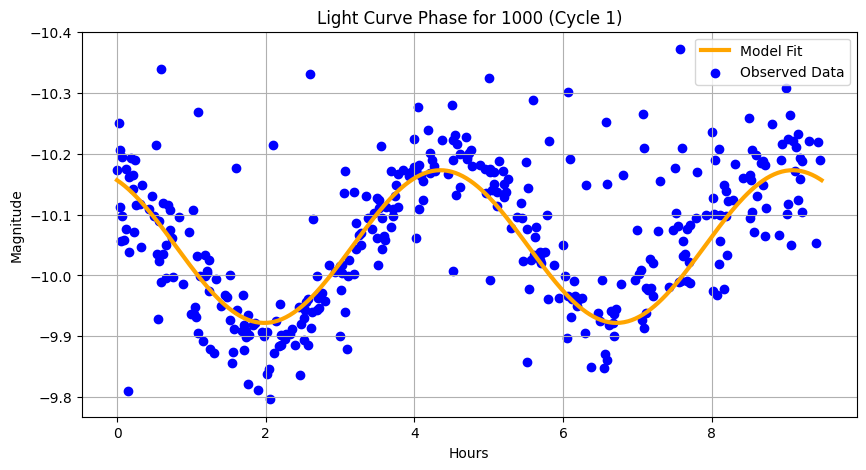

In [25]:
# Enter object ID to process here
object_id = "1000"
queue_single_asteroid_by_id(object_id)